In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os, re, glob, parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('muted')

ligan_root = 'C:\\Users\mtr22\Code\liGAN'
sys.path.append(ligan_root)
import results

print('SSHFS status\n------------')
print('Bridges {}'.format(os.path.exists('E:\\')))
print('CSB     {}'.format(os.path.exists('D:\\')))
print('CRC     {}'.format(os.path.exists('F:\\')))

SSHFS status
------------
Bridges False
CSB     False
CRC     False


# train.py

In [30]:
def read_err_file(err_file):
    error = None
    with open(err_file, encoding='utf-8') as f:
        for line in f:
            if not re.match('Warning.*', line) \
               and re.match(r'.*(Error|Exception|error|fault|failed).*', line):
                error = line.rstrip()
    return error

indent = 4*' '
train_output_files = []
for expt_dir in ['E:\\pylon5\\mc5phpp\\mtragoza\\liGAN\\train_molport\\loss_types']:
    
    for job_name in ['ae_disc_x_0', 'gen_e_disc_x_0']:
        
        job_dir = os.path.join(expt_dir, job_name)
        
        err_files = []
        for err_file in os.listdir(job_dir):

            m = re.match(r'slurm-(\d+)\.err', err_file)
            if not m:
                continue
            
            job_id = int(m.group(1))
            err_file = os.path.join(job_dir, err_file)
            error = read_err_file(err_file)
            err_files.append((job_id, err_file, error))
            
        for job_id, err_file, error in sorted(err_files):
            print(err_file + '\t' + str(error)[:72])
        
            try:
                train_output_file_pat = os.path.join(job_dir, str(job_id), '*.training_output')
                train_output_file = glob.glob(train_output_file_pat)[0]
                train_output_files.append(train_output_file)
            except IndexError:
                pass
            
        print()

len(train_output_files)

E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8581639.err	train.py: error: argument --cont_iter: expected one argument
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8602050.err	FileNotFoundError: [Errno 2] No such file or directory: '../../../models
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8631254.err	slurmstepd: error: *** JOB 8631254 ON gpu054 CANCELLED AT 2020-04-14T22:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8642393.err	slurmstepd: error: *** JOB 8642393 ON gpu052 CANCELLED AT 2020-04-15T10:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8663235.err	slurmstepd: error: *** JOB 8663235 ON gpu057 CANCELLED AT 2020-04-16T10:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\slurm-8696108.err	slurmstepd: error: *** JOB 8696108 ON gpu054 CANCELLED AT 2020-04-17T13:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport

E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-8916183.err	IndentationError: unindent does not match any outer indentation level
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-9110806.err	ModuleNotFoundError: No module named 'openbabel'
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-9111870.err	slurmstepd: error: *** JOB 9111870 ON gpu057 CANCELLED AT 2020-05-15T07:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-9144749.err	slurmstepd: error: *** JOB 9144749 ON gpu055 CANCELLED AT 2020-05-18T16:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-9156408.err	/var/slurmd/job9156408/slurm_script: line 72: 26670 Bus error           
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\slurm-9161885.err	slurmstepd: error: *** JOB 9161885 ON gpu052 CANCELLED AT 2020-05-20T01:
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molp

64

In [31]:
vae_name_format = 'gen_{gen_loss_type}_disc_{disc_loss_type}_{random_seed}'
ae_name_format  = 'ae_disc_{disc_loss_type}_{random_seed}'

train_job_dfs = []
for train_output_file in train_output_files:
    try:
        train_job_df = pd.read_csv(train_output_file, sep=' ')
        print(train_output_file)
    except Exception as e:
        print(train_output_file, e, file=sys.stderr)
        continue
    
    scr_dir = os.path.dirname(train_output_file)
    job_dir, job_id = os.path.split(scr_dir)
    expt_dir, job_name = os.path.split(job_dir)
    _, expt_name = os.path.split(expt_dir)

    out_file = '/'.join([expt_name, job_name, 'slurm-{}.out'.format(job_id)])
    err_file = '/'.join([expt_name, job_name, 'slurm-{}.err'.format(job_id)])
    
    train_job_df['expt_name'] = expt_name
    train_job_df['job_name'] = job_name
    train_job_df['model_name'] = job_name.rsplit('_', 1)[0]
    train_job_df['job_id'] = int(job_id)
    train_job_df['out_file'] = out_file
    train_job_df['err_file'] = err_file
    
    # get params from job_name
    try:
        job_params = parse.parse(vae_name_format, job_name).named
        variational = True
    except:
        job_params = parse.parse(ae_name_format, job_name).named
        variational = False
        
    train_job_df['variational'] = variational
    if not variational:
        train_job_df['gen_loss_type'] = 'e'
    
    for param, value in job_params.items():
        train_job_df[param] = value
    
    # get error from err_file
    #train_job_df['job_error'] = read_err_file(err_file)
    
    train_job_df = train_job_df.rename(columns=dict({'test_data': 'phase'}))
    
    train_job_dfs.append(train_job_df)

train_df = pd.concat(train_job_dfs)
train_df.set_index(['expt_name', 'job_name', 'job_id'])

E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8631254\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8642393\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8663235\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8696108\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8723294\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8740567\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8754090\ae_disc_x_0.molportFULL_rand_.0.0.training_output
E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\ae_disc_x_0\8819098\ae_disc_x_0.molportFULL_ra

E:\pylon5\mc5phpp\mtragoza\liGAN\train_molport\loss_types\gen_e_disc_x_0\9702041\gen_e_disc_x_0.molportFULL_rand_.0.0.training_output


iteration  phase  disc_log_loss  disc_iter  \
expt_name  job_name       job_id                                                
loss_types ae_disc_x_0    8631254          0  train       0.694079        0.0   
                          8631254          0   test       0.693985        0.0   
                          8642393          0  train       0.694079        0.0   
                          8642393          0   test       0.693985        0.0   
                          8642393        100  train       0.685052      100.0   
...                                      ...    ...            ...        ...   
           gen_e_disc_x_0 9702041     199800   test       0.409428   199800.0   
                          9702041     199900  train       0.527753   199900.0   
                          9702041     199900   test       0.420630   199900.0   
                          9702041     200000  train       0.329104   200000.0   
                          9702041     200000   test       0.363999   200000.0   

                                   disc_grad_norm  gen_L2_loss  \
expt_name  job_name       job_id                                 
loss_types ae_disc_x_0    8631254             1.0   751.627136   
                          8631254             1.0   742.808746   
                          8642393             1.0   751.627136   
                          8642393             1.0   742.808746   
                          8642393             1.0   578.113586   
...                                           ...          ...   
           gen_e_disc_x_0 9702041             1.0   331.880206   
                          9702041             1.0   347.194150   
                          9702041             1.0   360.531149   
                          9702041             1.0   388.418082   
                          9702041             1.0   388.759717   

                                   gen_adv_log_loss  gen_iter  gen_grad_norm  \
expt_name  job_name       job_id                                               
loss_types ae_disc_x_0    8631254          0.693492       0.0    1327.669309   
                          8631254          0.693456       0.0    1346.840322   
                          8642393          0.693492       0.0    1327.669889   
                          8642393          0.693456       0.0    1346.840900   
                          8642393          0.679477     100.0    1978.222463   
...                                             ...       ...            ...   
           gen_e_disc_x_0 9702041          8.609301  199800.0    5216.153244   
                          9702041          7.015627  199900.0    5945.492710   
                          9702041          7.339096  199900.0    5253.345440   
                          9702041          6.582237  200000.0    7717.132296   
                          9702041          6.326679  200000.0    7209.984638   

                                   gen_adv_grad_norm  gen_loss_weight  \
expt_name  job_name       job_id                                        
loss_types ae_disc_x_0    8631254                1.0              1.0   
                          8631254                1.0              1.0   
                          8642393                1.0              1.0   
                          8642393                1.0              1.0   
                          8642393                1.0              1.0   
...                                              ...              ...   
           gen_e_disc_x_0 9702041                1.0              1.0   
                          9702041                1.0              1.0   
                          9702041                1.0              1.0   
                          9702041                1.0              1.0   
                          9702041                1.0              1.0   

                                     model_name  \
expt_name  job_name       job_id                  
loss_types ae_disc_x_0    863

In [32]:
def second_min(x):
    try:
        return x.sort_values().iloc[1]
    except IndexError:
        return np.nan

train_df[train_df['phase'] == 'train'].groupby(['job_name', 'job_id'])[['iteration']].agg([min, second_min, max])

iteration                   
                             min second_min     max
job_name       job_id                              
ae_disc_x_0    8631254         0        NaN       0
               8642393         0      100.0    4300
               8663235         0      100.0    4900
               8696108         0      100.0    5000
               8723294         0      100.0   10000
               8740567         0      100.0   15100
               8754090         0      100.0   19300
               8819098         0      100.0   19300
               8828183         0      100.0   19300
               8828587         0      100.0   28800
               8831924         0      100.0   37600
               8857941         0      100.0   45200
               8858000         0      100.0   55000
               8906491         0      100.0   55000
               8916163         0      100.0   55000
               9110805         0      100.0   55000
               9111869         0      100.0   63900
               9144748         0      100.0   72500
               9156407         0      100.0   74200
               9161884         0      100.0   84300
               9172596         0      100.0   94200
               9192065         0      100.0  103500
               9198682         0      100.0  112400
gen_e_disc_x_0 8216432         0        NaN       0
               8353365         0        NaN       0
               8392859         0      100.0    5300
               8499276         0      100.0   10400
               8581659         0      100.0   10400
               8602070         0      100.0   14600
               8642413         0      100.0   14600
               8663255         0      100.0   14600
               8723315         0      100.0   14600
               8740587         0      100.0   15300
               8819119         0      100.0   15300
               8828203         0      100.0   15300
               8828607         0      100.0   24700
               8831944         0      100.0   34900
               8857961         0      100.0   43400
               8858020         0      100.0   43400
               8906511         0      100.0   43400
               8916183         0      100.0   43400
               9110806         0        NaN       0
               9111870         0    43000.0   53200
               9144749         0    43000.0   62500
               9156408         0    43000.0   62700
               9161885         0    43000.0   71900
               9172595         0    43000.0   62700
               9192064         0    43000.0   80700
               9198681         0    43000.0   89300
               9214779         0    43000.0   99700
               9234880         0    43000.0  108900
               9627154         0    43000.0  117600
               9656495         0    43000.0  126800
               9669068         0    43000.0  136000
               9669070         0    43000.0  126800
               9669072         0    43000.0  146000
               9669075         0    43000.0  126800
               9669077         0    43000.0  154000
               9669079         0    43000.0  164200
               9669081         0    43000.0  173900
               9669083         0    43000.0  183000
               9677372         0    43000.0  193100
               9677374         0    43000.0  200000
               9702041         0    43000.0  200000

In [33]:
train_df.groupby(['job_name', 'iteration', 'phase'])[['job_id']].agg(['count', min, max])

job_id                  
                                count      min      max
job_name       iteration phase                         
ae_disc_x_0    0         test      23  8631254  9198682
                         train     23  8631254  9198682
               100       test      22  8642393  9198682
                         train     22  8642393  9198682
               200       test      22  8642393  9198682
...                               ...      ...      ...
gen_e_disc_x_0 199800    train      2  9677374  9702041
               199900    test       2  9677374  9702041
                         train      2  9677374  9702041
               200000    test       2  9677374  9702041
                         train      2  9677374  9702041

[6252 rows x 3 columns]

In [34]:
agg_train_df = train_df.reset_index()
agg_train_df = agg_train_df.loc[agg_train_df.groupby(['job_name', 'iteration', 'phase'])['job_id'].idxmax()]
agg_train_df.groupby(['job_name', 'iteration', 'phase'])[['job_id']].agg(['count', min, max])

job_id                  
                                count      min      max
job_name       iteration phase                         
ae_disc_x_0    0         test       1  9198682  9198682
                         train      1  9198682  9198682
               100       test       1  9198682  9198682
                         train      1  9198682  9198682
               200       test       1  9198682  9198682
...                               ...      ...      ...
gen_e_disc_x_0 199800    train      1  9702041  9702041
               199900    test       1  9702041  9702041
                         train      1  9702041  9702041
               200000    test       1  9702041  9702041
                         train      1  9702041  9702041

[6252 rows x 3 columns]

# generate.py

In [11]:
expt_files = [
    #'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\csb_molport2.gen_metrics',
    #'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\crc_pubchem2.gen_metrics',
    #'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\bridges_pubchem2.gen_metrics',
    #'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\crc_molport3.gen_metrics',
    
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\crc_fit_molport2.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\csb_fit_pubchem2.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\csb_fit_molport2.gen_metrics',
]
expt_param_names = ['expt_name', 'cluster']
expt_name_format = '{cluster}_fit_{dataset}2'

expt_dfs = []
for expt_file in expt_files:
    expt_df = pd.read_csv(expt_file, sep=' ')
    expt_name = os.path.splitext(os.path.basename(expt_file))[0]
    expt_params = parse.parse(expt_name_format, expt_name).named
    expt_df['expt_name'] = expt_name
    expt_df['cluster'] = expt_params['cluster']
    expt_dfs.append(expt_df)
    print(expt_file)
        
fit_df = pd.concat(expt_dfs)

C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\crc_fit_molport2.gen_metrics


c:\users\mtr22\code\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (32,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\csb_fit_pubchem2.gen_metrics
C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\csb_fit_molport2.gen_metrics


In [20]:
from functools import lru_cache

job_param_names = ['job_name', 'variational', 'gen_loss_type', 'KL_loss_weight', 'L2_loss_weight',
                   'disc_loss_type', 'GAN_loss_weight', 'random_seed', 'train_job_name', 'loss_weights',
                   'iteration', 'prior', 'data_name', 'molport_sim', 'AE/VAE', 'posterior/prior', 'dataset', 'method']

job_name_formats = {
    'AE_molport': 'ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}',
    'AE_pubchem': 'ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_{data_name}',
    'VAE_molport': 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}' \
        '_{random_seed}_{iteration}_{fit_options}',
    'VAE_pubchem': 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}' \
        '_{random_seed}_{iteration}_{fit_options}_{data_name}',
}

@lru_cache(100)
def parse_job_name(job_name):

    variational = job_name.startswith('gen_')
    is_pubchem = 'pubchem' in job_name

    # get correct format for parsing job name
    if variational:
        if is_pubchem:
            job_name_format = job_name_formats['VAE_pubchem']
        else:
            job_name_format = job_name_formats['VAE_molport']
    else:
        if is_pubchem:
            job_name_format = job_name_formats['AE_pubchem']
        else:
            job_name_format = job_name_formats['AE_molport']
            
    # parse job name to get job params
    job_params = parse.parse(job_name_format, job_name).named
    job_params['job_name'] = job_name
    
    if variational:
        job_params['AE/VAE'] = 'VAE'
    else:
        job_params['AE/VAE'] = 'AE'
    
    if is_pubchem:
        job_params['dataset'] = 'pubchem'
        job_params['molport_sim'] = float(job_params['data_name'][len('pubchem_diff'):])
    else:
        job_params['data_name'] = 'molportFULL_rand_test0'
        job_params['dataset'] = 'molport'
        job_params['molport_sim'] = 1.0
        
    job_params['variational'] = variational
    
    if not variational:
        job_params['gen_loss_type'] = 'e'

    # parse fit_options flags into new boolean params
    fit_options = job_params['fit_options']
    job_params['prior'] = 'p' in fit_options
    job_params['random_rotation'] = 'r' in fit_options
    
    train_job_name_format = job_name_format.split('_{iteration}_')[0]
    job_params['train_job_name'] = train_job_name_format.format(**job_params)
    
    # convert data types of numeric params
    if variational:
        job_params['KL_loss_weight'] = float(job_params['KL_loss_weight'])
        job_params['L2_loss_weight'] = float(job_params['L2_loss_weight'])
        job_params['GAN_loss_weight'] = float(job_params['GAN_loss_weight'])
    else:
        job_params['KL_loss_weight'] = 1.0
        job_params['L2_loss_weight'] = 1.0
        job_params['GAN_loss_weight'] = 1.0
        
    job_params['iteration'] = int(job_params['iteration'])
    job_params['random_seed'] = int(job_params['random_seed'])
    
    # add other params
    job_params['AE/VAE'] = 'VAE' if job_params['variational'] else 'AE'
    job_params['posterior/prior'] = 'prior' if job_params['prior'] else 'posterior'
    job_params['method'] = ' '.join([job_params['AE/VAE'],
                                     job_params['posterior/prior']])
    job_params['loss_weights'] = str((job_params['KL_loss_weight'],
                                      job_params['L2_loss_weight'],
                                      job_params['GAN_loss_weight']))

    return pd.Series([job_params[p] for p in job_param_names])

fit_df[job_param_names] = fit_df['job_name'].apply(parse_job_name)

def dtype(series):
    return series.dtype

param_names = job_param_names + expt_param_names

fit_df[param_names + ['lig_name']].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
job_name,object,568,"[gen_e_0.1_0.1_disc_x_0.1_0_100000_pr, gen_e_0..."
variational,bool,2,"[True, False]"
gen_loss_type,object,1,[e]
KL_loss_weight,float64,3,"[0.1, 10.0, 1.0]"
L2_loss_weight,float64,3,"[0.1, 10.0, 1.0]"
disc_loss_type,object,1,[x]
GAN_loss_weight,float64,3,"[0.1, 10.0, 1.0]"
random_seed,int64,1,[0]
train_job_name,object,28,"[gen_e_0.1_0.1_disc_x_0.1_0, gen_e_0.1_0.1_dis..."
loss_weights,object,27,"[(0.1, 0.1, 0.1), (0.1, 0.1, 10.0), (0.1, 0.1,..."


In [21]:
fit_df['lig_fit_exact_types'] = (fit_df['lig_fit_type_diff'] == 0)
fit_df['lig_gen_fit_exact_types'] = (fit_df['lig_gen_fit_type_diff'] == 0)

fit_df['lig_fit_has_error']             = ~fit_df['lig_fit_error'].isnull()
fit_df['lig_gen_fit_has_error']         = ~fit_df['lig_gen_fit_error'].isnull()
fit_df['lig_fit_add_has_error']         = ~fit_df['lig_fit_add_error'].isnull()
fit_df['lig_fit_add_min_has_error']     = ~fit_df['lig_fit_add_min_error'].isnull()
fit_df['lig_gen_fit_add_has_error']     = ~fit_df['lig_gen_fit_add_error'].isnull()
fit_df['lig_gen_fit_add_min_has_error'] = ~fit_df['lig_gen_fit_add_min_error'].isnull()

fit_df['lig_fit_add_dvalid']     = fit_df['lig_fit_add_valid'].astype(int)     - fit_df['lig_fit_valid'].astype(int)
fit_df['lig_gen_fit_add_dvalid'] = fit_df['lig_gen_fit_add_valid'].astype(int) - fit_df['lig_gen_fit_valid'].astype(int)

fit_df['lig_logE']      = np.log10(fit_df['lig_E'])
fit_df['lig_min_logE']  = np.log10(fit_df['lig_min_E'])
fit_df['lig_dlogE_min'] = fit_df['lig_min_logE'] - fit_df['lig_logE']

fit_df['lig_gen_fit_add_logE']      = np.log10(fit_df['lig_gen_fit_add_E'])
fit_df['lig_gen_fit_add_min_logE']  = np.log10(fit_df['lig_gen_fit_add_min_E'])
fit_df['lig_gen_fit_add_dlogE_min'] = fit_df['lig_gen_fit_add_min_logE'] - fit_df['lig_gen_fit_add_logE']

fit_df['lig_gen_fit_add_dlogE_true']     = fit_df['lig_gen_fit_add_logE']     - fit_df['lig_logE']  
fit_df['lig_gen_fit_add_min_dlogE_true'] = fit_df['lig_gen_fit_add_min_logE'] - fit_df['lig_min_logE']

c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
pd.set_option('display.max_rows', 100)
metric_names = [c for c in fit_df.columns if c not in param_names]
fit_df[metric_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,457770.0,4.500000e+00,2.872284e+00,0.000000e+00,2.000000e+00,4.500000e+00,7.000000e+00,9.000000e+00
sample_idx,457770.0,4.500000e+00,2.872284e+00,0.000000e+00,2.000000e+00,4.500000e+00,7.000000e+00,9.000000e+00
lig_norm,457770.0,3.615908e+01,8.993985e+00,7.370781e+00,3.110332e+01,3.707800e+01,4.122034e+01,9.430122e+01
lig_gen_norm,457770.0,2.970308e+01,1.024623e+01,1.942692e-01,2.177268e+01,2.804027e+01,3.743571e+01,9.257838e+01
lig_latent_norm,457770.0,2.389634e+01,1.339499e+01,1.537599e-01,2.662226e+01,3.106098e+01,3.205093e+01,5.536523e+01
lig_gen_L2_loss,457770.0,3.786709e+02,4.241096e+02,5.351436e-01,4.619935e+01,1.334630e+02,7.225876e+02,4.759642e+03
lig_variance,457770.0,9.771855e+02,5.388799e+02,9.916216e-01,6.234532e+02,9.688627e+02,1.258380e+03,7.078902e+03
lig_gen_variance,457770.0,6.705692e+02,5.219648e+02,1.261178e-03,2.708633e+02,4.619068e+02,1.007941e+03,6.528206e+03
lig_fit_L2_loss,457770.0,5.671898e-02,5.384901e-01,5.921281e-07,6.203520e-05,8.577556e-05,1.288569e-04,4.513778e+01
lig_n_atoms,457770.0,2.424938e+01,9.883767e+00,2.000000e+00,1.800000e+01,2.400000e+01,2.900000e+01,7.700000e+01


In [25]:
from results import aggregate_data

agg_df = aggregate_data(fit_df[
    fit_df['train_job_name'].isin({
        'ae_disc_x_0',
        'gen_e_0.1_1_disc_x_10_0',
    })
], param_names + ['lig_name'], n_samples='count').reset_index()

inform_param_names = [
    'AE/VAE',
    'posterior/prior',
    'iteration',
    'dataset',
    'molport_sim',
]

agg_df.groupby(inform_param_names)[['array_idx', 'lig_name']] \
    .agg({'array_idx': ['count', 'min', 'max'], 'lig_name': 'count'})

array_idx             \
                                                         count min    max   
AE/VAE posterior/prior iteration dataset molport_sim                        
AE     posterior       10000     molport 1.0               213   1  12601   
                       20000     molport 1.0               213   2  12602   
                       30000     molport 1.0               212   3  12603   
                       40000     molport 1.0               211   4  12604   
                       50000     molport 1.0               210   5  12605   
                       60000     molport 1.0               210   6  12606   
                       70000     molport 1.0               210   7  12607   
                       80000     molport 1.0               210   8  12608   
                       90000     molport 1.0               210   9  12609   
                       100000    molport 1.0               210  10  12610   
                                 pubchem 0.0                14  10    140   
                                         0.1               999   9   9999   
                                         0.2              1000   8   9998   
                                         0.3              1000   7   9997   
                                         0.4              1000   6   9996   
                                         0.5              1000   5   9995   
                                         0.6              1000   4   9994   
                                         0.7              1000   3   9993   
                                         0.8              1000   2   9992   
                                         0.9              1000   1   9991   
VAE    posterior       10000     molport 1.0               632   1  22571   
                       20000     molport 1.0               629   1  22542   
                       30000     molport 1.0               632   1  22573   
                       40000     molport 1.0               632   1  22574   
                       50000     molport 1.0               567   1  22545   
                       60000     molport 1.0               541   1  22546   
                       70000     molport 1.0               540   1  22547   
                       80000     molport 1.0               540   1  22548   
                       90000     molport 1.0               541   1  22549   
                       100000    molport 1.0               542   1  22550   
                                 pubchem 0.0                14  10    279   
                                         0.1               999  10  19997   
                                         0.2              1000  10  19995   
                                         0.3              1000  10  19993   
                                         0.4              1000  10  19991   
                                         0.5              1000  10  19989   
                                         0.6              1000   7  19987   
                                         0.7              1000   5  19985   
                                         0.8              1000   3  19983   
                                         0.9              1000   1  19981   
       prior           10000     molport 1.0               624   1  22551   
                       20000     molport 1.0               629   1  22552   
                       30000     molport 1.0               630   1  22553   
                       40000     molport 1.0               629   1  22554   
                       50000     molport 1.0               541   1  22555   
                       60000     molport 1.0               542   1  22556   
                       70000     molport 1.0               542   1  22557   
                       80000     molport 1.0               541   1  22558   
                       90000     molport 1.0               543   1  22559   
                       100000    molport 1.0     

In [ ]:
except_cols = ['lig_name', 'lig_latent_norm', 'lig_latent_variance']
lig_col_map = {}
lig_gen_col_map = {}
other_cols = []

for col in fit_df.columns:
    if col in except_cols:
        pass
    elif col.startswith('lig_gen'):
        lig_gen_col_map[col] = col[8:]
    elif col.startswith('lig'):
        lig_col_map[col] = col[4:]
    else:
        other_cols.append(col)

lig_df = fit_df[except_cols + list(lig_col_map.keys()) + other_cols]
lig_df['density_type'] = 'lig'
lig_df = lig_df.rename(columns=lig_col_map)
lig_df['L2_loss'] = 0.0

lig_gen_df = fit_df[except_cols + list(lig_gen_col_map.keys()) + other_cols]
lig_gen_df['density_type'] = 'lig_gen'
lig_gen_df = lig_gen_df.rename(columns=lig_gen_col_map)

fit_df2 = pd.concat([lig_df, lig_gen_df])

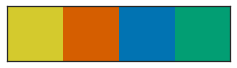

In [26]:
def shift(a, n):
    return np.array([a[(i+n)%len(a)] for i in range(len(a))])

colors = sns.color_palette('colorblind')
color_names = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'teal']
colors = pd.Series(colors, index=color_names)
colors['yellow'] = tuple(0.9 * np.array(colors['yellow']))
colors = colors[['yellow', 'red', 'blue', 'green']]

sns.set_palette(colors)
sns.set_context('notebook')
sns.set_style('white')

sns.palplot(colors)

In [28]:
pd.set_option('display.max_row', 150)
pd.set_option('display.max_columns', 150)

# possible reasons for invalidity:
# n_atoms = 0
# n_frags > 1
# rdkit sanitization
#    bad explicit valence
#    failed to kekulize

error_pat = re.compile(r'.*((valence)|(kekulize)|(RingInfo)|(converged)|(bad direction)|(bad params)|(no points)).*', re.DOTALL)
def parse_error(error):
    if pd.isnull(error):
        return 'No error'
    else:
        try:
            m = error_pat.match(error)
            if m.group(2):
                return 'Explicit valence greater than permitted'
            elif m.group(3):
                return 'Failed to kekulize molecule'
            elif m.group(4):
                return 'RingInfo not initialized'
            elif m.group(5):
                return 'Minimization did not converge'
            elif m.group(6):
                return 'Bad line search direction'
            elif m.group(7):
                return 'Bad params pointer'
            elif m.group(8):
                return 'No points to minimize'
        except AttributeError as e:
            print(error)
            raise e

fit_df['lig_fit_no_atoms']            = fit_df['lig_fit_n_atoms'] == 0
fit_df['lig_fit_add_no_atoms']        = fit_df['lig_fit_n_atoms'] == 0

fit_df['lig_fit_multi_frags']         = fit_df['lig_fit_n_frags'] > 1
fit_df['lig_fit_add_multi_frags']     = fit_df['lig_fit_add_n_frags'] > 1

fit_df['lig_fit_error_type']          = fit_df['lig_fit_error'].map(parse_error)
fit_df['lig_fit_add_error_type']      = fit_df['lig_fit_add_error'].map(parse_error)
fit_df['lig_fit_add_min_error_type']  = fit_df['lig_fit_add_min_error'].map(parse_error)

error_metric_names = ['lig_fit_no_atoms', 
                      'lig_fit_multi_frags', 'lig_fit_add_multi_frags',
                      'lig_fit_error_type', 'lig_fit_add_error_type']

fit_df.groupby(error_metric_names + ['lig_fit_add_valid'])[['sample_idx']].count()

sample_idx
lig_fit_no_atoms lig_fit_multi_frags lig_fit_add_multi_frags lig_fit_error_type                      lig_fit_add_error_type                  lig_fit_add_valid            
False            False               False                   Explicit valence greater than permitted Explicit valence greater than permitted False                   12724
                                                                                                     No error                                True                    10523
                                                             No error                                Explicit valence greater than permitted False                   35654
                                                                                                     Failed to kekulize molecule             False                      30
                                                                                                     No error                                True                   392077
                 True                False                   Explicit valence greater than permitted Explicit valence greater than permitted False                     336
                                                                                                     No error                                True                       12
                                                             No error                                Explicit valence greater than permitted False                     302
                                                                                                     No error                                True                     4414
                                     True                    Explicit valence greater than permitted Explicit valence greater than permitted False                      36
                                                             No error                                No error                                False                    1662

In [30]:
def get_invalid_reason(row):
    ret = []
    for base in ['lig_fit',  'lig_gen_fit', 'lig_fit_add', 'lig_gen_fit_add']:
        
        reasons = []
        if row[base+'_no_atoms']:
            reasons.append('No atoms')
            
        if row[base+'_multi_frags']:
            reasons.append('Multiple disconnected fragments')
            
        if row[base+'_has_error']:
            reasons.append(row[base+'_error_type'])
            
        if reasons:
            ret.append(', '.join(reasons))
        else:
            ret.append('Valid molecule')
        
    return pd.Series(ret)

fit_df[['lig_fit_reason', 'lig_gen_fit_reason', 'lig_fit_add_reason', 'lig_gen_fit_add_reason']] \
    = fit_df.apply(get_invalid_reason, axis=1)

In [31]:
os.chdir('C:\\Users\\mtr22\\Code\\ipython-notebooks')

In [32]:
fit_df['Method'] = fit_df['method'].apply(lambda x: x.replace('_', ' '))
fit_df['Mol. sim. to train'] = fit_df['molport_sim']
fit_df['Iteration'] = fit_df['iteration']

method_order = [
    'Real density',
    'AE posterior',
    'VAE posterior',
    'VAE prior',
]
method_order_map = {mtd: i for i, mtd in enumerate(method_order)}
fit_df['method_order'] = fit_df['Method'].map(method_order_map.__getitem__)
fit_df = fit_df.sort_values('method_order', kind='mergesort')

In [ ]:
from collections import OrderedDict
from results import plot_lines

plot_df = agg_train_df[(agg_train_df['phase'] == 'test') &
                       (agg_train_df['iteration'] <= 200000)].copy()

k = 5000
plot_df['Iteration'] = (plot_df['iteration']//k)*k

plot_df['Gen. L2 loss']      = plot_df['gen_L2_loss']
plot_df['Gen. adv. loss']    = plot_df['gen_adv_log_loss']
plot_df['Disc. loss']        = plot_df['disc_log_loss']
plot_df['Gen. KL-div. loss'] = plot_df['gen_kldiv_loss']

plot_df['Method'] = plot_df['variational'].map(lambda x: ('AE', 'VAE')[x])

x = 'Iteration'
y = [
    'Gen. L2 loss',
    'Gen. adv. loss',
    'Disc. loss',
    'Gen. KL-div. loss',
]
hue = 'Method'
hue_order = method_order

fig = plot_lines('train_loss.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors[1:3],
                 n_cols=4, height=3, width=3, alpha=0.5, despine=True)

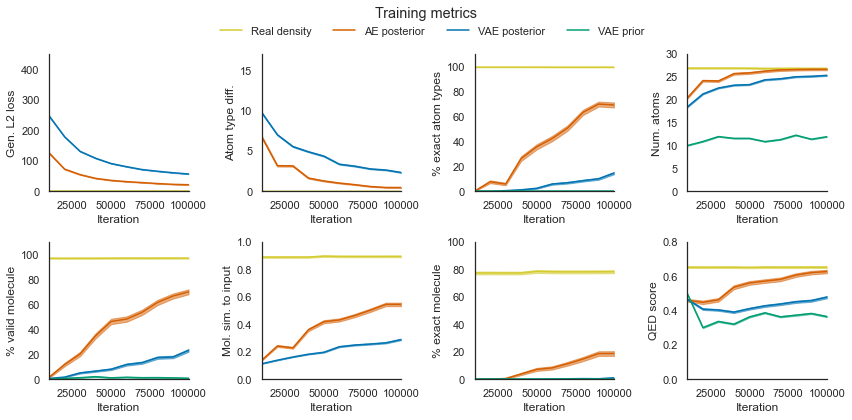

In [49]:
from results import plot_lines

plot_df = fit_df[
    (fit_df['dataset'] == 'molport') &
    (fit_df['train_job_name'].isin(
    {
        'ae_disc_x_0',
        'gen_e_0.1_1_disc_x_10_0'
    }))
]

lig_plot_df = plot_df.copy()
lig_plot_df = lig_plot_df[lig_plot_df['Method'] == 'VAE posterior'] # same dataset for each method, so drop duplicates
lig_gen_plot_df = plot_df.copy()

lig_plot_df['Gen. L2 loss']       = 0
lig_plot_df['Atom type diff.']    = lig_plot_df['lig_fit_type_diff']
lig_plot_df['% exact atom types'] = (lig_plot_df['lig_fit_type_diff'] == 0) * 100
lig_plot_df['Num. atoms']         = lig_plot_df['lig_n_atoms']
lig_plot_df['Mol. sim. to input'] = lig_plot_df['lig_fit_add_ob_sim']
lig_plot_df['% valid molecule']   = lig_plot_df['lig_fit_valid'] * 100
lig_plot_df['% exact molecule']   = lig_plot_df['lig_fit_add_SMILES_match'] * 100
lig_plot_df['QED score']          = lig_plot_df['lig_QED']
lig_plot_df['Method'] = 'Real density'

lig_gen_plot_df['Gen. L2 loss']       = lig_gen_plot_df['lig_gen_L2_loss']
lig_gen_plot_df['Atom type diff.']    = lig_gen_plot_df['lig_gen_fit_type_diff']
lig_gen_plot_df['% exact atom types'] = (lig_gen_plot_df['lig_gen_fit_type_diff'] == 0) * 100
lig_gen_plot_df['Num. atoms']         = lig_gen_plot_df['lig_gen_fit_n_atoms']
lig_gen_plot_df['Mol. sim. to input'] = lig_gen_plot_df['lig_gen_fit_add_ob_sim']
lig_gen_plot_df['% valid molecule']   = lig_gen_plot_df['lig_gen_fit_valid'] * 100
lig_gen_plot_df['% exact molecule']   = lig_gen_plot_df['lig_gen_fit_add_SMILES_match'] * 100
lig_gen_plot_df['QED score']          = lig_gen_plot_df['lig_gen_fit_add_QED']

plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

iter_bin_size = 1
if iter_bin_size > 1:
    plot_df['Iteration'] = (plot_df['iteration']//iter_bin_size)*iter_bin_size
    
x = 'Iteration'
y = [
    'Gen. L2 loss',
    'Atom type diff.',
    '% exact atom types',
    'Num. atoms',
    '% valid molecule',
    'Mol. sim. to input',
    '% exact molecule',
    'QED score'
]
ylim = [
    (0, 450), (0, 17), (0, 110), (0, 30),
    (0, 110), (0, 1), (0, 100), (0, 0.8)
]
hue = 'Method'
hue_order = method_order

fig = plot_lines('train_fit_metrics.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors,
                  n_cols=4, height=3, width=3, despine=True, lead_x=0, ylim=ylim,
                  title='Training metrics', center_lgd=True, lgd_title=False)

#for i, ax in enumerate(fig.axes):
#    ax.set_xticks(range(0, 200001, 25000)[1:])
#    ax.set_xlim(10000, 200000)


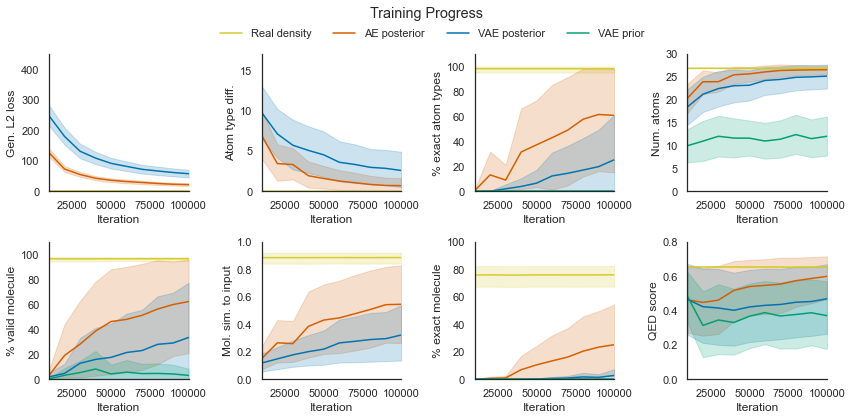

In [50]:
plot2_df = \
    plot_df.groupby([hue, x, 'lig_name']) \
    [y].agg(['max', 'mean', 'min']) \
    .groupby([hue, x]).mean().stack()

fig = plot_lines('train_fit_metrics2.png', plot2_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors,
                  n_cols=4, height=3, width=3, despine=True, lead_x=0, ylim=ylim, range_=True, alpha=1/5,
                  title='Training Progress', center_lgd=True, lgd_title=False, lgd_h=0.895)

% valid molecules, pass 1  % valid molecules, pass 2
Method                                                                  
AE posterior  max                   76.789082                  98.413403
              mean                  52.011539                  87.084212
              min                   21.169422                  57.328304
Real density  max                   93.709087                  95.917009
              mean                  92.344391                  95.081549
              min                   88.294685                  92.621769
VAE posterior max                   62.465328                  99.711528
              mean                  24.261622                  82.886386
              min                    2.230112                  33.163209
VAE prior     max                   10.118717                 100.000000
              mean                   1.067902                  91.583269
              min                    0.000000                  41.839565

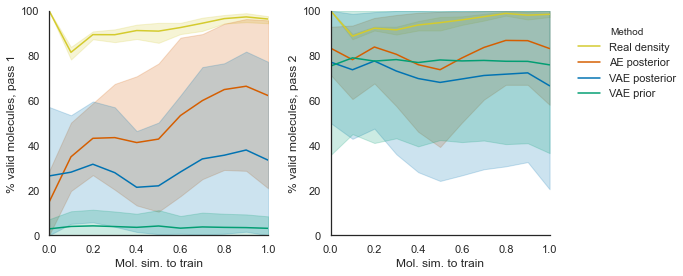

In [52]:
# NOTE the filled in areas are not the standard deviation/standard error
# and they're not the range (i.e. min and max) of the metrics being plotted,
# they are the range of the mean sample metrics- sample min, sample
# mean, and sample max, i.e. the expected sample min, mean and max
#
# for boolean metrics, e.g. lig_gen_fit_add_valid, lig_gen_fit_add_SMILES_match, etc:
# sample MAX  = ANY sample is true
# sample MEAN = FRACTION of samples that are true
# sample MIN  = ALL samples are true

plot_df = fit_df[
    (fit_df['iteration'] == 100000) &
    (fit_df['train_job_name'].isin(
    {
        'ae_disc_x_0',
        'gen_e_0.1_1_disc_x_10_0'
    }))
]

lig_plot_df = plot_df.copy()
lig_gen_plot_df = plot_df.copy()

lig_plot_df['% valid molecules, pass 1'] = plot_df['lig_fit_valid'] * 100
lig_plot_df['% valid molecules, pass 2'] = (plot_df['lig_fit_valid'] | plot_df['lig_fit_add_valid']) * 100
lig_plot_df['Method'] = 'Real density'

lig_gen_plot_df['% valid molecules, pass 1'] = plot_df['lig_gen_fit_valid'] * 100
lig_gen_plot_df['% valid molecules, pass 2'] = (plot_df['lig_gen_fit_valid'] | plot_df['lig_gen_fit_add_valid']) * 100

plot_df = pd.concat([lig_plot_df, lig_gen_plot_df]).sort_values('method_order')

x = 'Mol. sim. to train'
y = ['% valid molecules, pass 1', '% valid molecules, pass 2']
hue = 'Method'
hue_order = method_order

tab_df = \
    plot_df[plot_df[x] < 1.0].groupby([hue, 'lig_name']) \
    [y].agg(['max', 'mean', 'min']) \
    .groupby([hue]).mean().stack()

plot_df = \
    plot_df.groupby([hue, x, 'lig_name']) \
    [y].agg(['max', 'mean', 'min']) \
    .groupby([hue, x]).mean().stack()

ylim  = [(0, 100)] * 2

fig = plot_lines('mol_validity2.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors,
                 n_cols=3, height=4, width=4, ylim=ylim, alpha=1/5,
                 despine=True, lead_x=0, range_=True)
tab_df

sample_idx  \
Method        Reason for invalid mol.                                          
AE posterior  Explicit valence greater than permitted                   8244   
              Multiple disconnected fragments                           2489   
              Multiple disconnected fragments and\nexplicit v...         181   
              No atoms                                                   727   
              Valid molecule                                           78489   
Real density  Explicit valence greater than permitted                  11601   
              Multiple disconnected fragments                           1662   
              Multiple disconnected fragments and\nexplicit v...          36   
              Valid molecule                                          257221   
VAE posterior Explicit valence greater than permitted                  10735   
              Multiple disconnected fragments                           4131   
              Multiple disconnected fragments and\nexplicit v...         362   
              No atoms                                                   199   
              Valid molecule                                           74773   
VAE prior     Explicit valence greater than permitted                   4666   
              Multiple disconnected fragments                           2862   
              Multiple disconnected fragments and\nexplicit v...          63   
              Valid molecule                                           82599   

                                                                  % of all generated molecules  
Method        Reason for invalid mol.                                                           
AE posterior  Explicit valence greater than permitted                                 9.146788  
              Multiple disconnected fragments                                         2.761567  
              Multiple disconnected fragments and\nexplicit v...                      0.200821  
              No atoms                                                                0.806613  
              Valid molecule                                                         87.084212  
Real density  Explicit valence greater than permitted                                 4.288408  
              Multiple disconnected fragments                                         0.614372  
              Multiple disconnected fragments and\nexplicit v...                      0.013308  
              Valid molecule                                                         95.083912  
VAE posterior Explicit valence greater than permitted                                11.901330  
              Multiple disconnected fragments                                         4.579823  
              Multiple disconnected fragments and\nexplicit v...                      0.401330  
              No atoms                                                                0.220621  
              Valid molecule                                                         82.896896  
VAE prior     Explicit valence greater than permitted                                 5.173523  
              Multiple disconnected fragments                                         3.173301  
              Multiple disconnected fragments and\nexplicit v...                      0.069853  
              Valid molecule                                                         91.583324

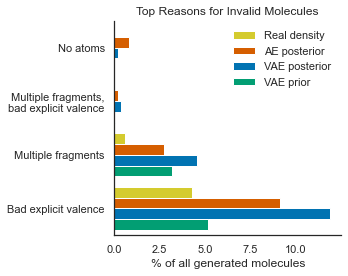

In [54]:
sns.color_palette(colors)

def fix_reason(row):
    rsn = row.iloc[0]
    if rsn != 'Valid molecule':
        rsn = row.iloc[1]
    return rsn[0].upper() + rsn[1:].replace(', ', ' and\n').lower()


plot_df = fit_df[
    (fit_df['iteration'] == 100000) &
    (fit_df['dataset'] == 'pubchem') &
    (fit_df['train_job_name'].isin(
    {
        'ae_disc_x_0',
        'gen_e_0.1_1_disc_x_10_0'
    }))
]

lig_plot_df = plot_df.copy()
lig_gen_plot_df = plot_df.copy()

lig_plot_df['Reason for invalid mol.'] = \
    plot_df[['lig_fit_reason', 'lig_fit_add_reason']].apply(fix_reason, axis=1)
lig_plot_df['Method'] = 'Real density'

lig_gen_plot_df['Reason for invalid mol.'] = \
    plot_df[['lig_gen_fit_reason', 'lig_gen_fit_add_reason']].apply(fix_reason, axis=1)

plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

plot_df = \
    plot_df.groupby(['Method', 'Reason for invalid mol.']) \
    [['sample_idx']].count()

plot_df['% of all generated molecules'] = \
    plot_df / plot_df.groupby(['Method'])[['sample_idx']].agg('sum') * 100

tab_df = plot_df

plot_df = plot_df.reset_index()

reason_order = [
    'Valid molecule',
    'Explicit valence greater than permitted',
    'Multiple disconnected fragments',
    'Multiple disconnected fragments and\nexplicit valence greater than permitted',
    'Failed to kekulize molecule',
    'No atoms',
][::-1]
reason_order_map = {rsn: i for i, rsn in enumerate(reason_order)}

plot_df['reason_order'] = plot_df['Reason for invalid mol.'].map(reason_order_map.__getitem__)

abbrev_reason = {
    'Valid molecule': 'Valid',
    'Explicit valence greater than permitted': 'Bad explicit valence',
    'Multiple disconnected fragments': 'Multiple fragments',
    'Multiple disconnected fragments and\nexplicit valence greater than permitted': 'Multiple fragments,\nbad explicit valence',
    'Failed to kekulize molecule': 'Failed to Kekulize',
    'No atoms': 'No atoms'
}
plot_df['Reason for invalid mol.'] = plot_df['Reason for invalid mol.'].map(abbrev_reason.__getitem__)

plot_df = plot_df.sort_values('reason_order', kind='mergesort')

phi = (1 + np.sqrt(5))/2
fig, axes = plt.subplots(1, 1, figsize=(5, 4)) #, gridspec_kw=dict(width_ratios=[phi, 1]))

# bar plot of reasons for invalid molecules
ax = axes #[0]
sns.barplot(x='% of all generated molecules',
            y='Reason for invalid mol.',
            hue='Method',
            hue_order=method_order,
            data=plot_df[plot_df['Reason for invalid mol.'] != 'Valid'],
            saturation=1.0, ax=ax)

#ax.set_xlim(0, 20)
ax.legend(loc='upper right', frameon=False, title=None)
ax.set_title('Top Reasons for Invalid Molecules', fontsize='medium')
#ax.title.set_position([0.5, 1.05])
ax.set_ylabel('')

if False:
    # line plot of mol validity wrt sampling
    ax = axes[1]

    plot_df = fit_df[(fit_df['iteration'] == 100000)]

    lig_plot_df = plot_df.copy()
    lig_gen_plot_df = plot_df.copy()

    lig_plot_df['% valid molecules'] = (plot_df['lig_fit_valid'] | plot_df['lig_fit_add_valid']) * 100
    lig_plot_df['Method'] = 'Real density'

    lig_gen_plot_df['% valid molecules'] = (plot_df['lig_gen_fit_valid'] | plot_df['lig_gen_fit_add_valid']) * 100
    #lig_gen_plot_df['Method'] = 'Generated'

    plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

    plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

    # this is a hack to get the inital point in the sampling plot
    init_df = pd.DataFrame({
        'Method': ['Real density', 'AE posterior', 'VAE posterior', 'VAE prior'],
        'lig_name': ['dummy', 'dummy', 'dummy', 'dummy'],
        'sample_idx': [-1, -1, -1, -1],
        '% valid molecules': [False, False, False, False]
    })
    #plot_df = init_df.append(plot_df)


    plot_df['% molecules with any valid sample'] = \
        plot_df.groupby(['Method', 'lig_name'])[['% valid molecules']].cummax()

    plot_df['# samples'] = plot_df['sample_idx'] + 1

    sns.lineplot(x='# samples',
                 y='% molecules with any valid sample',
                 hue='Method',
                 data=plot_df, ax=ax)


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], loc='lower right', frameon=False, title=None)
    ax.set_title('2. Sampling Valid Molecules')

    ax.set_xlim(1, 10)
    ax.set_ylim(0, 110)
    ax.set_xticks(range(1, 11, 2))

    #fig.suptitle('Validity of Generated Molecules')

sns.despine(fig)
fig.tight_layout(rect=[0, 0, 1, 1])
fig.savefig('mol_validity_bars.png')

tab_df

Mol. sim. to train % exact atom types % exact molecule  \
                                   mean               mean             mean   
Method       level_2                                                          
AE posterior max                   0.45          60.481512        29.840801   
             mean                  0.45          39.801074        11.459354   
             min                   0.45          12.110571         1.040100   
Real density max                   0.45          99.579730        85.698519   
             mean                  0.45          97.455272        78.011020   
             min                   0.45          90.400658        66.985548   

                     Atom-only RMSD Bonded RMSD method_order  
                               mean        mean         mean  
Method       level_2                                          
AE posterior max           0.344147    0.248057            1  
             mean          0.280703    0.211613            1  
             min           0.230220    0.184802            1  
Real density max           0.037984    0.032086            0  
             mean          0.010311    0.009800            0  
             min           0.001588    0.001244            0

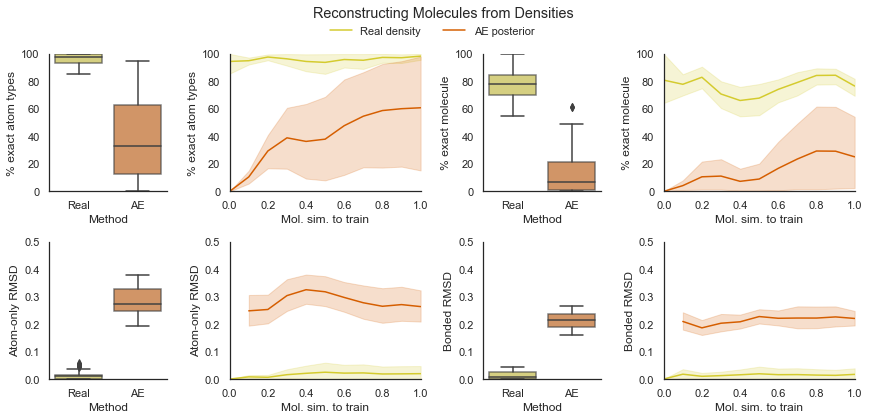

In [58]:
from results import plot_lines

# to demonstrate effectivesness of atom fitting on ideal densities,
# show % time we fit exact atom types, then rmsd to true coords (no bonds),
# then % of time we add correct bonds, then rmsd to true molecule

plot_df = fit_df[
    (fit_df['iteration'] == 100000) &
    (fit_df['variational'] == False) &
    (fit_df['prior'] == False) &
    (fit_df['train_job_name'].isin(
    {
        'ae_disc_x_0',
        'gen_e_0.1_1_disc_x_10_0'
    }))
].copy()

plot_df['Mol. sim. to train'] = plot_df['molport_sim']

lig_plot_df = plot_df.copy()
lig_gen_plot_df = plot_df.copy()

lig_plot_df['% exact atom types'] = (plot_df['lig_fit_type_diff'] == 0).astype(int) * 100
lig_plot_df['% exact molecule']   = plot_df['lig_fit_add_SMILES_match'].astype(int) * 100
lig_plot_df['Atom-only RMSD']     = plot_df['lig_fit_RMSD']
lig_plot_df['Bonded RMSD']        = plot_df['lig_fit_add_RMSD_true']
lig_plot_df['Method'] = 'Real density'

lig_gen_plot_df['% exact atom types'] = (plot_df['lig_gen_fit_type_diff'] == 0).astype(int) * 100
lig_gen_plot_df['% exact molecule']   = plot_df['lig_gen_fit_add_SMILES_match'].astype(int) * 100
lig_gen_plot_df['Atom-only RMSD']     = plot_df['lig_gen_fit_RMSD']
lig_gen_plot_df['Bonded RMSD']        = plot_df['lig_gen_fit_add_RMSD_true']

plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

y = [
    '% exact atom types', '% exact molecule',
    'Atom-only RMSD',     'Bonded RMSD',
]

# mean of sample min, mean, and max
plot_df = plot_df \
    .groupby(['Method', 'Mol. sim. to train', 'lig_name'])[y] \
    .agg(['min', 'mean', 'max']) \
    .groupby(['Method', 'Mol. sim. to train']) \
    .mean().stack().reset_index()

# the previous command changes method order
plot_df['method_order'] = plot_df['Method'].map(method_order_map.__getitem__)
plot_df = plot_df.sort_values('method_order', kind='mergesort')

x = 'Mol. sim. to train'

y = [
    None, y[0], None, y[1],
    None, y[2], None, y[3],
]
ylim = [(0, 100)]*4 \
     + [(0, 0.5)]*4

hue = 'Method'
hue_order = method_order[:2]

fig = plot_lines('atom_fitting_recon.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors[:2],
                 n_cols=4, height=3, width=3, ylim=ylim, alpha=1/5,
                 despine=True, lead_x=0, range_=True, gridspec_kw=dict(width_ratios=[1, phi, 1, phi]),
                 title='Reconstructing Molecules from Densities', center_lgd=True, lgd_title=False)

plot_df = plot_df[plot_df['Mol. sim. to train'] < 1.0]

ax = fig.axes[0]
sns.boxplot(y='% exact atom types', x=hue, data=plot_df,
            boxprops=dict(alpha=2/3), ax=ax)
ax.set_ylim(0, 100)
ax.set_xticklabels(['Real', 'AE'])

ax = fig.axes[2]
sns.boxplot(y='% exact molecule', x=hue, data=plot_df,
            boxprops=dict(alpha=2/3), ax=ax)
ax.set_ylim(0, 100)
ax.set_xticklabels(['Real', 'AE'])

ax = fig.axes[4]
sns.boxplot(y='Atom-only RMSD', x=hue, data=plot_df,
            boxprops=dict(alpha=2/3), ax=ax)
ax.set_ylim(0, 0.5)
ax.set_xticklabels(['Real', 'AE'])

ax = fig.axes[6]
sns.boxplot(y='Bonded RMSD', x=hue, data=plot_df,
            boxprops=dict(alpha=2/3), ax=ax)
ax.set_ylim(0, 0.5)
ax.set_xticklabels(['Real', 'AE'])

lgd = fig.axes[-1].get_legend()
fig.savefig('atom_fitting_recon.png', bbox_inches='tight')

plot_df.groupby([hue, 'level_2']).agg(['mean']) #.stack().transpose().unstack()

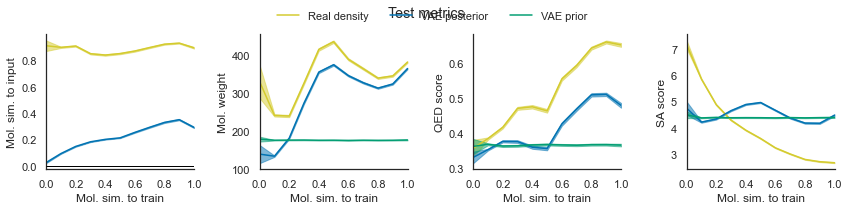

In [62]:
from results import plot_lines

plot_df = fit_df[
    (fit_df['iteration'] == 100000) &
    (fit_df['variational']) &
    (fit_df['train_job_name'].isin(
    {
        'ae_disc_x_0',
        'gen_e_0.1_1_disc_x_10_0'
    }))
]

lig_plot_df = plot_df.copy()
lig_plot_df = lig_plot_df[lig_plot_df['Method'] == 'VAE posterior'] # same dataset for each method, so drop duplicates
lig_gen_plot_df = plot_df.copy()

lig_plot_df['Gen. L2 loss']       = 0
lig_plot_df['Atom type diff.']    = lig_plot_df['lig_fit_type_diff']
lig_plot_df['% exact atom types'] = (lig_plot_df['lig_fit_type_diff'] == 0)
lig_plot_df['Num. atoms']         = lig_plot_df['lig_n_atoms']
lig_plot_df['Mol. sim. to input'] = lig_plot_df['lig_fit_add_ob_sim']
lig_plot_df['% valid molecule']   = lig_plot_df['lig_fit_valid']
lig_plot_df['% exact molecule']   = lig_plot_df['lig_fit_add_SMILES_match']
lig_plot_df['Mol. weight']        = lig_plot_df['lig_fit_add_MW']
lig_plot_df['QED score']          = lig_plot_df['lig_fit_add_QED']
lig_plot_df['SA score']           = lig_plot_df['lig_fit_add_SAS']
lig_plot_df['NPS']                = lig_plot_df['lig_fit_add_NPS']
lig_plot_df['Method'] = 'Real density'

lig_gen_plot_df['Gen. L2 loss']       = lig_gen_plot_df['lig_gen_L2_loss']
lig_gen_plot_df['Atom type diff.']    = lig_gen_plot_df['lig_gen_fit_type_diff']
lig_gen_plot_df['% exact atom types'] = (lig_gen_plot_df['lig_gen_fit_type_diff'] == 0)
lig_gen_plot_df['Num. atoms']         = lig_gen_plot_df['lig_gen_fit_n_atoms']
lig_gen_plot_df['Mol. sim. to input'] = lig_gen_plot_df['lig_gen_fit_add_ob_sim']
lig_gen_plot_df['% valid molecule']   = lig_gen_plot_df['lig_gen_fit_valid']
lig_gen_plot_df['% exact molecule']   = lig_gen_plot_df['lig_gen_fit_add_SMILES_match']
lig_gen_plot_df['Mol. weight']        = lig_gen_plot_df['lig_gen_fit_add_MW']
lig_gen_plot_df['QED score']          = lig_gen_plot_df['lig_gen_fit_add_QED']
lig_gen_plot_df['SA score']           = lig_gen_plot_df['lig_gen_fit_add_SAS']
lig_gen_plot_df['NPS']                = lig_gen_plot_df['lig_gen_fit_add_NPS']


plot_df = pd.concat([lig_plot_df, lig_gen_plot_df])

x = 'Mol. sim. to train'
y = [
    'Mol. sim. to input',
    'Mol. weight',
    'QED score',
    'SA score',
]
hue = 'Method'

hue_order = [method_order[0], method_order[2], method_order[3]]
_colors    = np.array([colors[0], colors[2], colors[3]])

fig = plot_lines('test_fit_metrics.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=_colors,
                  n_cols=4, height=3, width=3, despine=True, lead_x=0, #ylim=ylim,
                  title='Test metrics', center_lgd=True, lgd_title=False)

for i, ax in enumerate(fig.axes):
    xticks = np.arange(0, 1.1, 0.2)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['%.1f'%xt for xt in xticks])
    ax.set_xlim(0.0, 1.0)


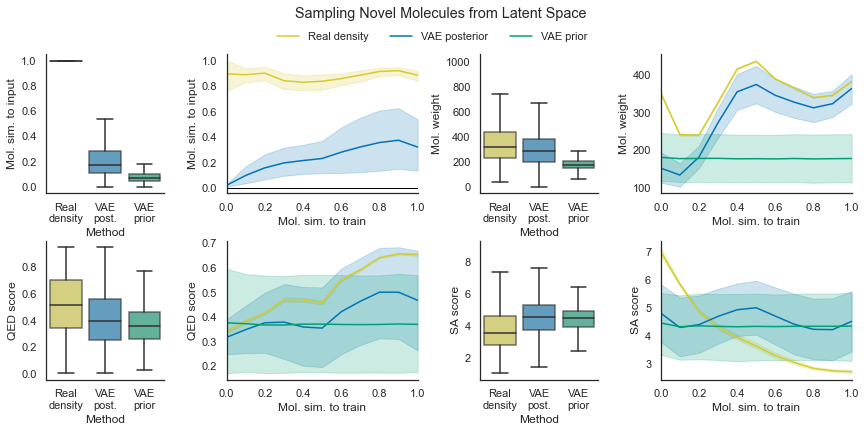

In [63]:
plot2_df = \
    plot_df.groupby([hue, x, 'lig_name']) \
    [y].agg(['max', 'mean', 'min']) \
    .groupby([hue, x]).mean().stack()

x = 'Mol. sim. to train'
_y = [
    None, 'Mol. sim. to input',
    None, 'Mol. weight',
    None, 'QED score',
    None, 'SA score',
]
hue = 'Method'

fig = plot_lines('test_fit_metrics2.png', plot2_df, x=x, y=_y, hue=hue, hue_order=hue_order, colors=_colors,
                  n_cols=4, height=3, width=3, despine=True, lead_x=0, range_=True, alpha=1/5, #ylim=ylim,
                  title='Sampling Novel Molecules from Latent Space', center_lgd=True, lgd_title=False,
                  gridspec_kw=dict(width_ratios=[1, phi, 1, phi]), lgd_h=0.915)

plot3_df = plot_df[plot_df['dataset'] == 'pubchem']

for i, ax in enumerate(fig.axes):
    if i%2 == 0:
        sns.boxplot(y=_y[i+1], x=hue, data=plot3_df,
                    boxprops=dict(alpha=2/3), fliersize=0, palette=_colors, ax=ax)
        ax.set_xticklabels(['Real\ndensity', 'VAE\npost.', 'VAE\nprior'])
    else:
        xticks = np.arange(0, 1.1, 0.2)
        ax.set_xticks(xticks)
        ax.set_xticklabels(['%.1f'%xt for xt in xticks])
        ax.set_xlim(0.0, 1.0)

fig.savefig('latent_sampling.png', bbox_inches='tight')

In [69]:
seed = 564813

332822


c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


'C:\\Users\\mtr22\\Code\\ipython-notebooks'

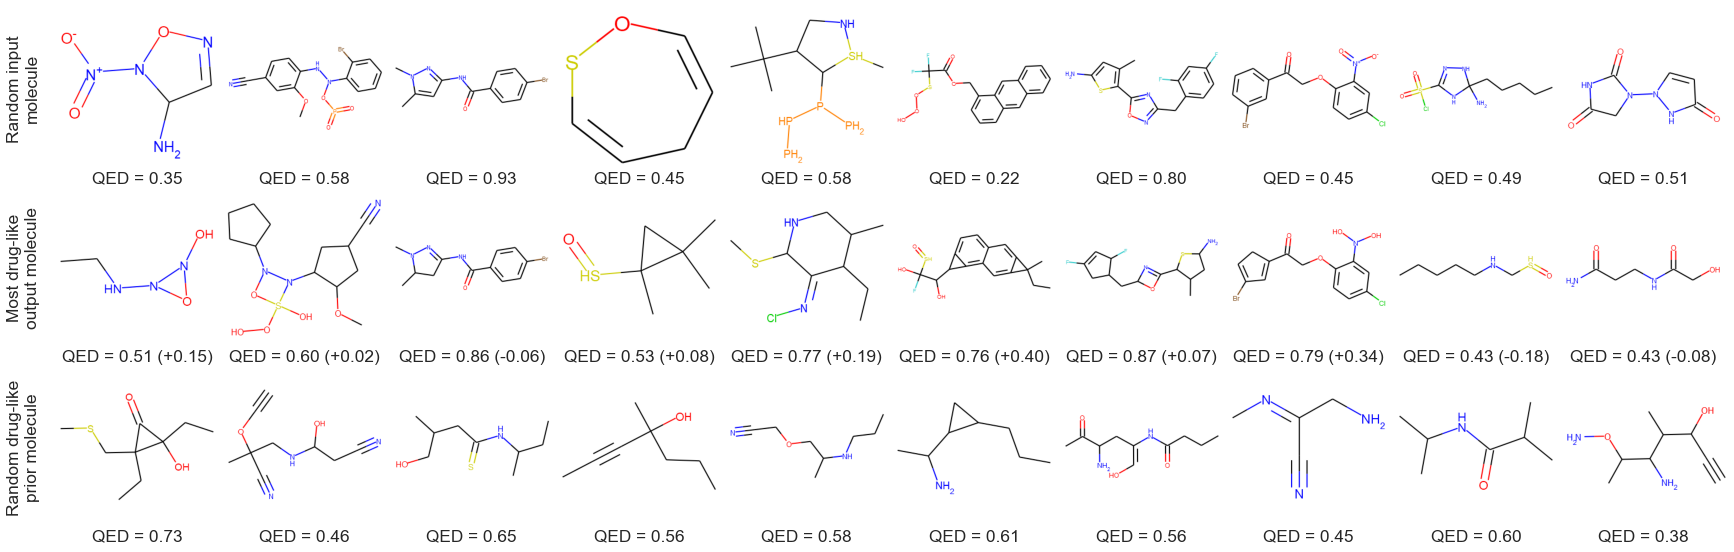

In [85]:
import matplotlib.image as mpimg
from rdkit import Chem

def smi_to_image(smi):
    mol = Chem.MolFromSmiles(smi)
    return Chem.Draw.MolToImage(mol)

mol_df = fit_df[(fit_df['dataset'] == 'pubchem') &
                (fit_df['iteration'] == 100000)  &
                (fit_df['variational'] == True) &
                (fit_df['prior'] == False)].copy()

mol_df = mol_df[mol_df['lig_fit_add_valid'] & mol_df['lig_gen_fit_add_valid']]
mol_df['Change in QED'] = mol_df['lig_gen_fit_add_QED'] - mol_df['lig_QED']

n_mols = 10


print(seed)
#np.random.seed(seed)
mols = mol_df['lig_name'].unique()
np.random.shuffle(mols)
mols = set(mols[:n_mols])
mol_df = mol_df[mol_df['lig_name'].map(mols.__contains__)]
mol_df = mol_df[~mol_df['Change in QED'].isna()].reset_index()
mol_df = mol_df.iloc[mol_df.groupby('lig_name')['Change in QED'].idxmax()]
mol_df['lig_im'] = mol_df['lig_SMILES'].map(smi_to_image)
mol_df['lig_fit_add_im'] = mol_df['lig_fit_add_SMILES'].map(smi_to_image)
mol_df['lig_gen_fit_add_im'] = mol_df['lig_gen_fit_add_SMILES'].map(smi_to_image)
mol_df

pri_df = fit_df[(fit_df['dataset'] == 'pubchem') &
                (fit_df['iteration'] == 100000)  &
                (fit_df['variational'] == True) &
                (fit_df['prior'] == True)].copy()
pri_df = pri_df[pri_df['lig_name'].map(mols.__contains__)]
pri_df = pri_df[pri_df['lig_gen_fit_add_valid'] & (~pri_df['lig_gen_fit_add_QED'].isna())].reset_index()
pri_df = pri_df.iloc[pri_df.groupby('lig_name')['lig_gen_fit_add_QED'].idxmax()]
pri_df['lig_gen_fit_add_im'] = pri_df['lig_gen_fit_add_SMILES'].map(smi_to_image)
pri_df

n_ims = 3
ims = ['lig_fit_add_im', 'lig_gen_fit_add_im', 'lig_gen_fit_add_im']
qeds = ['lig_fit_add_QED', 'lig_gen_fit_add_QED', 'lig_gen_fit_add_QED']

n_rows = n_ims*2
n_cols = n_mols
width = height = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(width*n_cols, height*n_rows//2 * 1.1),
                         gridspec_kw=dict(height_ratios=[10, 1, 10, 1, 10, 1]))

for mol_idx in range(n_mols):
    post_row = mol_df.iloc[mol_idx]
    pri_row = pri_df.iloc[mol_idx]
    for im_idx in range(n_ims):
        
        if im_idx == 2:
            row = pri_row
        else:
            row = post_row
            
        im = row[ims[im_idx]]
        qed = row[qeds[im_idx]]

        ax = axes[2*im_idx, mol_idx]
        ax.imshow(im, aspect='auto')
        
        ax = axes[2*im_idx+1, mol_idx]
        text = 'QED = {:.2f}'.format(qed)
        if im_idx == 1:
            qed_imp = row['Change in QED']
            text += ' ({}{:.2f})'.format(['', '+'][qed_imp>0], qed_imp)
        ax.text(0.5, 0.5, text, transform=ax.transAxes, 
                horizontalalignment='center', verticalalignment='center', fontsize='x-large')

for ax in axes.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
axes[0,0].set_ylabel('Random input\nmolecule', fontsize='x-large')
axes[2,0].set_ylabel('Most drug-like\noutput molecule', fontsize='x-large')
axes[4,0].set_ylabel('Random drug-like\nprior molecule', fontsize='x-large')
    
sns.despine(fig, top=True, bottom=True, left=True, right=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('vae_post_mols.png', bbox_inches='tight')
os.getcwd()

In [84]:
seed = int(np.random.rand() * 1000000) # 958772 653066

In [451]:
lat_df = fit_df[(fit_df['dataset'] == 'molport') &
                (fit_df['iteration'] == 100000)  &
                (fit_df['variational'] == False) &
                (fit_df['prior'] == False)]

lat_df.sort_values('lig_gen_fit_add_QED', ascending=False)

,Unnamed: 0,lig_name,sample_idx,lig_norm,lig_gen_norm,lig_latent_norm,lig_gen_L2_loss,lig_variance,lig_gen_variance,lig_fit_L2_loss,lig_n_atoms,lig_fit_n_atoms,lig_radius,lig_fit_radius,lig_fit_type_diff,lig_fit_RMSD,lig_fit_time,lig_gen_fit_L2_loss,lig_gen_fit_n_atoms,lig_gen_fit_radius,lig_gen_fit_type_diff,lig_gen_fit_RMSD,lig_gen_fit_time,lig_n_frags,lig_error,lig_valid,lig_fit_n_frags,lig_fit_error,lig_fit_valid,lig_fit_add_n_frags,lig_fit_add_error,lig_fit_add_valid,lig_SMILES,lig_fit_add_SMILES,lig_fit_add_SMILES_match,lig_fit_add_morgan_sim,lig_fit_add_rdkit_sim,lig_fit_add_maccs_sim,lig_MW,lig_logP,lig_QED,lig_SAS,lig_NPS,lig_fit_add_MW,lig_fit_add_logP,lig_fit_add_QED,lig_fit_add_SAS,lig_fit_add_NPS,lig_E,lig_min_E,lig_dE_min,lig_min_error,lig_RMSD_min,lig_fit_add_E,lig_fit_add_min_E,lig_fit_add_dE_min,lig_fit_add_min_error,lig_fit_add_RMSD_min,lig_fit_add_dE_true,lig_fit_add_min_dE_true,lig_fit_add_RMSD_true,lig_fit_add_min_RMSD_true,lig_gen_fit_n_frags,lig_gen_fit_error,lig_gen_fit_valid,lig_gen_fit_add_n_frags,lig_gen_fit_add_error,lig_gen_fit_add_valid,lig_gen_fit_add_SMILES,lig_gen_fit_add_SMILES_match,lig_gen_fit_add_morgan_sim,lig_gen_fit_add_rdkit_sim,lig_gen_fit_add_maccs_sim,lig_gen_fit_add_MW,lig_gen_fit_add_logP,lig_gen_fit_add_QED,lig_gen_fit_add_SAS,lig_gen_fit_add_NPS,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_true,lig_gen_fit_add_min_dE_true,lig_gen_fit_add_RMSD_true,lig_gen_fit_add_min_RMSD_true,job_name,array_idx,expt_name,cluster,dataset,variational,gen_loss_type,disc_loss_type,random_seed,fit_options,prior,random_rotation,constrain_types,atom_init,AE/VAE,posterior/prior,method,molport_sim,iteration,lig_fit_has_error,lig_gen_fit_has_error,lig_fit_add_has_error,lig_fit_add_min_has_error,lig_gen_fit_add_has_error,lig_gen_fit_add_min_has_error,lig_fit_add_dvalid,lig_gen_fit_add_dvalid,lig_logE,lig_min_logE,lig_dlogE_min,lig_gen_fit_add_logE,lig_gen_fit_add_min_logE,lig_gen_fit_add_dlogE_min,lig_gen_fit_add_dlogE_true,lig_gen_fit_add_min_dlogE_true,lig_fit_add_obfp2_sim,lig_gen_fit_add_obfp2_sim,lig_fit_no_atoms,lig_fit_add_multi_frags,lig_fit_error_type,lig_fit_add_error_type,lig_fit_add_min_error_type,lig_gen_fit_no_atoms,lig_gen_fit_multi_frags,lig_gen_fit_add_multi_frags,lig_gen_fit_error_type,lig_gen_fit_add_error_type,lig_gen_fit_add_error_min_type,lig_fit_add_reason,lig_gen_fit_add_reason,Method,Mol. sim. to train,Iteration,method_order,lig_fit_add_no_atoms,lig_gen_fit_add_no_atoms,lig_fit_multi_frags,lig_fit_reason,lig_gen_fit_reason
86582,2,2054212_2,2,33.719921,33.238445,0.340807,8.466222,816.683716,796.972595,0.000149,21.0,21.0,4.979565,4.979708,0.0,0.001166,19.011119,4.292871,21.0,5.034244,0.0,0.154849,18.971103,1.0,NaN,True,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.000000,1.000000,1.000000,307.346,2.78992,0.948100,1.756797,-2.261978,307.346,2.78992,0.9481,1.756797,-2.261978,66.823889,43.974142,-22.849748,NaN,0.438765,66.875310,43.974142,-22.901168,NaN,4.387505e-01,0.051420,-2.132283e-08,0.001151,0.000014,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.000000,1.000000,1.000000,307.346,2.78992,0.9481,1.756797,-2.261978,469.352362,43.974142,-425.378221,NaN,4.607011e-01,402.528549,-2.258529e-08,0.149705,0.000019,ae_disc_x_0_100000_r_none,179,csb_molport2,csb,molport,False,e,x,0,r,False,True,False,none,AE,posterior,AE_posterior,1.0,100000,False,False,False,False,False,False,0,0,1.824932,1.643197,-0.181734,2.671499,1.643197,-1.028302,0.846567,-2.231744e-10,1.000000,1.000000,False,False,No error,No error,No error,False,False,False,No error,No error,No error,Valid molecule,Valid molecule,AE posterior,1.0,100000,1,False,False,False,Valid molecule,Valid molecule
86581,1,2054212_2,1,33.720146,33.726227,0.349937,9.585426,726.693787,729.750000,0.000076,21.0,21.0,4.979565,4.979663,0.0,0.000744,19.099331,5.480505,21.0,5.020443,0.0

In [517]:
lat_df = fit_df[(fit_df['dataset'] == 'molport') &
                (fit_df['iteration'] == 100000)  &
                (fit_df['variational'] == True) &
                (fit_df['prior'] == False)]

lat_df.sort_values('lig_gen_fit_add_QED', ascending=False)

,Unnamed: 0,lig_name,sample_idx,lig_norm,lig_gen_norm,lig_latent_norm,lig_gen_L2_loss,lig_variance,lig_gen_variance,lig_fit_L2_loss,lig_n_atoms,lig_fit_n_atoms,lig_radius,lig_fit_radius,lig_fit_type_diff,lig_fit_RMSD,lig_fit_time,lig_gen_fit_L2_loss,lig_gen_fit_n_atoms,lig_gen_fit_radius,lig_gen_fit_type_diff,lig_gen_fit_RMSD,lig_gen_fit_time,lig_n_frags,lig_error,lig_valid,lig_fit_n_frags,lig_fit_error,lig_fit_valid,lig_fit_add_n_frags,lig_fit_add_error,lig_fit_add_valid,lig_SMILES,lig_fit_add_SMILES,lig_fit_add_SMILES_match,lig_fit_add_morgan_sim,lig_fit_add_rdkit_sim,lig_fit_add_maccs_sim,lig_MW,lig_logP,lig_QED,lig_SAS,lig_NPS,lig_fit_add_MW,lig_fit_add_logP,lig_fit_add_QED,lig_fit_add_SAS,lig_fit_add_NPS,lig_E,lig_min_E,lig_dE_min,lig_min_error,lig_RMSD_min,lig_fit_add_E,lig_fit_add_min_E,lig_fit_add_dE_min,lig_fit_add_min_error,lig_fit_add_RMSD_min,lig_fit_add_dE_true,lig_fit_add_min_dE_true,lig_fit_add_RMSD_true,lig_fit_add_min_RMSD_true,lig_gen_fit_n_frags,lig_gen_fit_error,lig_gen_fit_valid,lig_gen_fit_add_n_frags,lig_gen_fit_add_error,lig_gen_fit_add_valid,lig_gen_fit_add_SMILES,lig_gen_fit_add_SMILES_match,lig_gen_fit_add_morgan_sim,lig_gen_fit_add_rdkit_sim,lig_gen_fit_add_maccs_sim,lig_gen_fit_add_MW,lig_gen_fit_add_logP,lig_gen_fit_add_QED,lig_gen_fit_add_SAS,lig_gen_fit_add_NPS,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_true,lig_gen_fit_add_min_dE_true,lig_gen_fit_add_RMSD_true,lig_gen_fit_add_min_RMSD_true,job_name,array_idx,expt_name,cluster,dataset,variational,gen_loss_type,disc_loss_type,random_seed,fit_options,prior,random_rotation,constrain_types,atom_init,AE/VAE,posterior/prior,method,molport_sim,iteration,lig_fit_has_error,lig_gen_fit_has_error,lig_fit_add_has_error,lig_fit_add_min_has_error,lig_gen_fit_add_has_error,lig_gen_fit_add_min_has_error,lig_fit_add_dvalid,lig_gen_fit_add_dvalid,lig_logE,lig_min_logE,lig_dlogE_min,lig_gen_fit_add_logE,lig_gen_fit_add_min_logE,lig_gen_fit_add_dlogE_min,lig_gen_fit_add_dlogE_true,lig_gen_fit_add_min_dlogE_true,lig_fit_add_obfp2_sim,lig_gen_fit_add_obfp2_sim,lig_fit_no_atoms,lig_fit_add_multi_frags,lig_fit_error_type,lig_fit_add_error_type,lig_fit_add_min_error_type,lig_gen_fit_no_atoms,lig_gen_fit_multi_frags,lig_gen_fit_add_multi_frags,lig_gen_fit_error_type,lig_gen_fit_add_error_type,lig_gen_fit_add_error_min_type,lig_fit_add_reason,lig_gen_fit_add_reason,Method,Mol. sim. to train,Iteration,method_order,lig_fit_add_no_atoms,lig_gen_fit_add_no_atoms,lig_fit_multi_frags,lig_fit_reason,lig_gen_fit_reason
270540,4,1063564_15,4,47.074955,45.577454,32.377304,247.258331,1625.902954,1507.616089,0.002734,28.0,28.0,7.873607,7.870922,0.0,0.034128,22.986877,19.548965,22.0,7.013309,6.0,NaN,17.596073,1.0,NaN,True,1.0,NaN,True,1.0,NaN,True,O=C(COC(=O)c1ccccc1C(F)(F)F)c1ccc(-c2ccccc2)cc1,O=C(COC(=O)c1ccccc1C(F)(F)F)c1ccc(-c2ccccc2)cc1,True,1.000000,1.000000,1.000000,384.353,5.41210,0.436257,1.862699,-0.905013,384.353,5.41210,0.436257,1.862699,-0.905013,102.947455,59.899274,-43.048181,NaN,0.621179,120.285463,59.899274,-60.386189,NaN,6.235317e-01,17.338008,-9.413895e-08,0.033150,0.000095,2.0,NaN,False,1.0,NaN,True,OC1(c2ccc(C3=CCC=C3)cc2)COC(C2CCCC2)O1,False,0.083333,0.405333,0.340909,298.382,3.73810,0.923637,3.906017,1.346516,750870.512454,58.589568,-750811.922886,NaN,1.184255e+00,750767.564998,-1.309706,NaN,NaN,gen_e_disc_x_0_100000_r_none,735,csb_molport2,csb,molport,True,e,x,0,r,False,True,False,none,VAE,posterior,VAE_posterior,1.0,100000,False,False,False,False,False,False,0,1,2.012616,1.777422,-0.235194,5.875565,1.767820,-4.107745,3.862949,-0.009601,1.000000,0.305344,False,False,No error,No error,No error,False,True,False,No error,No error,No error,Valid molecule,Valid molecule,VAE posterior,1.0,100000,2,False,False,False,Valid molecule,Multiple disconnected fragments
265033,7,743176_4,7,38.298473,38.111191,30.877642,235.575821,1080.158081,987.177063,0.000074,25.0,25.0,6.842743,6.84266

In [595]:
latent_dir = 'C:\\Users\\mtr22\\3D Objects\\gen_paper'

latent_metrics_files = [
    'ae_disc_x_0_100000_rsi_pose_interp_rand\\latent_interp1.gen_metrics',
    'gen_e_disc_x_0_100000_rsi_pose_interp_rand\\latent_interp1.gen_metrics',
    'ae_disc_x_0_100000_rsi_pubchem_diff0.5_head_10\\latent_interp1.gen_metrics',
    'gen_e_disc_x_0_100000_rsi_pubchem_diff0.5_head_10\\latent_interp1.gen_metrics',
]
latent_names = [
    'ae_pose_interp1_2_3',
    'gen_e_pose_interp1_8_9',
    'ae_latent_interp1_8_9',
    'gen_e_latent_interp1_6_7',
]
interp_ligs = [
    ('2054212_1', '2054212_2'),
    ('2054212_4', '2054212_5'),
    ('PubChem-121314654_0', 'PubChem-79970953_0'),
    ('PubChem-118526673_0',  'PubChem-118185755_0')
]

lat_dfs = []
for i, latent_metrics_file in enumerate(latent_metrics_files):
    lat_df = pd.read_csv(latent_dir + '\\fixed_batch_size\\' + latent_metrics_file, sep=' ')
    lat_df['job_name'] = os.path.dirname(latent_metrics_file).rsplit('_', 2)[0]
    lat_df['latent_idx'] = i
    lat_df['latent_name'] = latent_names[i]
    lig0, lig1 = interp_ligs[i]
    cond = (lig0 == lat_df['lig_name']) | (lig1 == lat_df['lig_name'])
    assert cond.any(), (latent_names[i], interp_ligs[i])
    lat_dfs.append(lat_df[cond])

lat_df = pd.concat(lat_dfs)
lat_df[job_param_names] = lat_df['job_name'].apply(parse_job_name)

lat_df.groupby(['latent_name', 'lig_name'])[['sample_idx']].count()

sample_idx
latent_name              lig_name                       
ae_latent_interp1_8_9    PubChem-121314654_0          10
                         PubChem-79970953_0           10
ae_pose_interp1_2_3      2054212_1                    10
                         2054212_2                    10
gen_e_latent_interp1_6_7 PubChem-118185755_0          10
                         PubChem-118526673_0          10
gen_e_pose_interp1_8_9   2054212_4                    10
                         2054212_5                    10

In [596]:
lat_df['interp_idx'] = 1
lat_df['interp_idx'] = lat_df.groupby('latent_name')['interp_idx'].cumsum() - 1
lat_df['lig_idx'] = lat_df['interp_idx'] // 10 # n_samples
lat_df.set_index('latent_name')

,lig_name,sample_idx,lig_norm,lig_gen_norm,lig_latent_norm,lig_gen_L2_loss,lig_variance,lig_gen_variance,lig_fit_L2_loss,lig_n_atoms,lig_fit_n_atoms,lig_radius,lig_fit_radius,lig_fit_type_diff,lig_fit_RMSD,lig_fit_time,lig_gen_fit_L2_loss,lig_gen_fit_n_atoms,lig_gen_fit_radius,lig_gen_fit_type_diff,lig_gen_fit_RMSD,lig_gen_fit_time,lig_n_frags,lig_error,lig_valid,lig_fit_n_frags,lig_fit_error,lig_fit_valid,lig_fit_add_n_frags,lig_fit_add_error,lig_fit_add_valid,lig_SMILES,lig_fit_add_SMILES,lig_fit_add_SMILES_match,lig_fit_add_morgan_sim,lig_fit_add_rdkit_sim,lig_fit_add_maccs_sim,lig_MW,lig_logP,lig_QED,lig_SAS,lig_NPS,lig_fit_add_MW,lig_fit_add_logP,lig_fit_add_QED,lig_fit_add_SAS,lig_fit_add_NPS,lig_E,lig_min_E,lig_dE_min,lig_min_error,lig_RMSD_min,lig_fit_add_E,lig_fit_add_min_E,lig_fit_add_dE_min,lig_fit_add_min_error,lig_fit_add_RMSD_min,lig_fit_add_dE_true,lig_fit_add_min_dE_true,lig_fit_add_RMSD_true,lig_fit_add_min_RMSD_true,lig_gen_fit_n_frags,lig_gen_fit_error,lig_gen_fit_valid,lig_gen_fit_add_n_frags,lig_gen_fit_add_error,lig_gen_fit_add_valid,lig_gen_fit_add_SMILES,lig_gen_fit_add_SMILES_match,lig_gen_fit_add_morgan_sim,lig_gen_fit_add_rdkit_sim,lig_gen_fit_add_maccs_sim,lig_gen_fit_add_MW,lig_gen_fit_add_logP,lig_gen_fit_add_QED,lig_gen_fit_add_SAS,lig_gen_fit_add_NPS,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_true,lig_gen_fit_add_min_dE_true,lig_gen_fit_add_RMSD_true,lig_gen_fit_add_min_RMSD_true,job_name,latent_idx,variational,gen_loss_type,disc_loss_type,random_seed,fit_options,prior,random_rotation,constrain_types,atom_init,AE/VAE,posterior/prior,method,molport_sim,iteration,interp_idx,lig_idx
latent_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ae_pose_interp1_2_3,2054212_1,0,33.720127,33.927299,0.348281,8.055750,6.055756e-12,82.744125,0.000075,21.0,21.0,4.979602,4.979799,0.0,0.000614,18.473939,4.030839,21.0,4.922661,0.0,0.137625,18.437440,1.0,NaN,True,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.0,1.000000,1.0,307.346,2.78992,0.948100,1.756797,-2.261978,307.346,2.78992,0.948100,1.756797,-2.261978,89.022585,43.092210,-45.930374,NaN,0.439517,88.837355,43.092210,-45.745144,NaN,4.394459e-01,-0.185230,3.656432e-09,0.000571,0.000022,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.000000,1.000000,1.000000,307.346,2.78992,0.948100,1.756797,-2.261978,2.900075e+02,4.397414e+01,-2.460333e+02,NaN,4.909677e-01,2.009822e+02,8.819315e-01,0.135008,0.010305,ae_disc_x_0_100000_rsi_pose,0,False,e,x,0,rsi,False,True,False,pose,AE,posterior,AE_posterior,1.0,100000,0,0
ae_pose_interp1_2_3,2054212_1,1,33.720127,33.668114,0.348409,9.995463,6.055756e-12,56.533287,0.000075,21.0,21.0,4.979602,4.979799,0.0,0.000614,18.403051,4.206567,21.0,4.881114,0.0,0.167187,18.216656,1.0,NaN,True,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.0,1.000000,1.0,307.346,2.78992,0.948100,1.756797,-2.261978,307.346,2.78992,0.948100,1.756797,-2.261978,89.022585,43.092210,-45.930374,NaN,0.439517,88.837355,43.092210,-45.745144,NaN,4.394459e-01,-0.185230,3.656432e-09,0.000571,0.000022,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.000000,1.000000,1.000000,307.346,2.78992,0.948100,1.756797,-2.261978,3.606952e+02,4.397414e+01,-3.167211e+02,NaN,5.171308e-01,2.716700e+02,8.819314e-01,0.161439,0.010305,ae_disc_x_0_100000_rsi_pose,0,False,e,x,0,rsi,False,True,False,pose,AE,posterior,AE_posterior,1.0,100000,1,0
ae_pose_interp1_2_3,2054212_1,2,33.720127,33.300594,0.348557,15.637877,6.055756e-12,33.405613,0.000075,21.0,21.0,4.979602,4.979799,0.0,0.000614,18.265874,6.204336,21.0,4.897818,0.0,0.405467,18.202699,1.0,NaN,True,1.0,NaN,True,1.0,NaN,True,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,Cc1ccc(F)cc1NC(=O)c1ccccc1S(C)(=O)=O,True,1.0,1.000000,1.0,307.346,2.78

In [597]:
interp_idxs = np.round(np.linspace(1, 19, 10, endpoint=True)).astype(int)
interp_idxs, interp_idxs[1:] - interp_idxs[:-1]

(array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2]))

'C:\\Users\\mtr22\\Code\\ipython-notebooks'

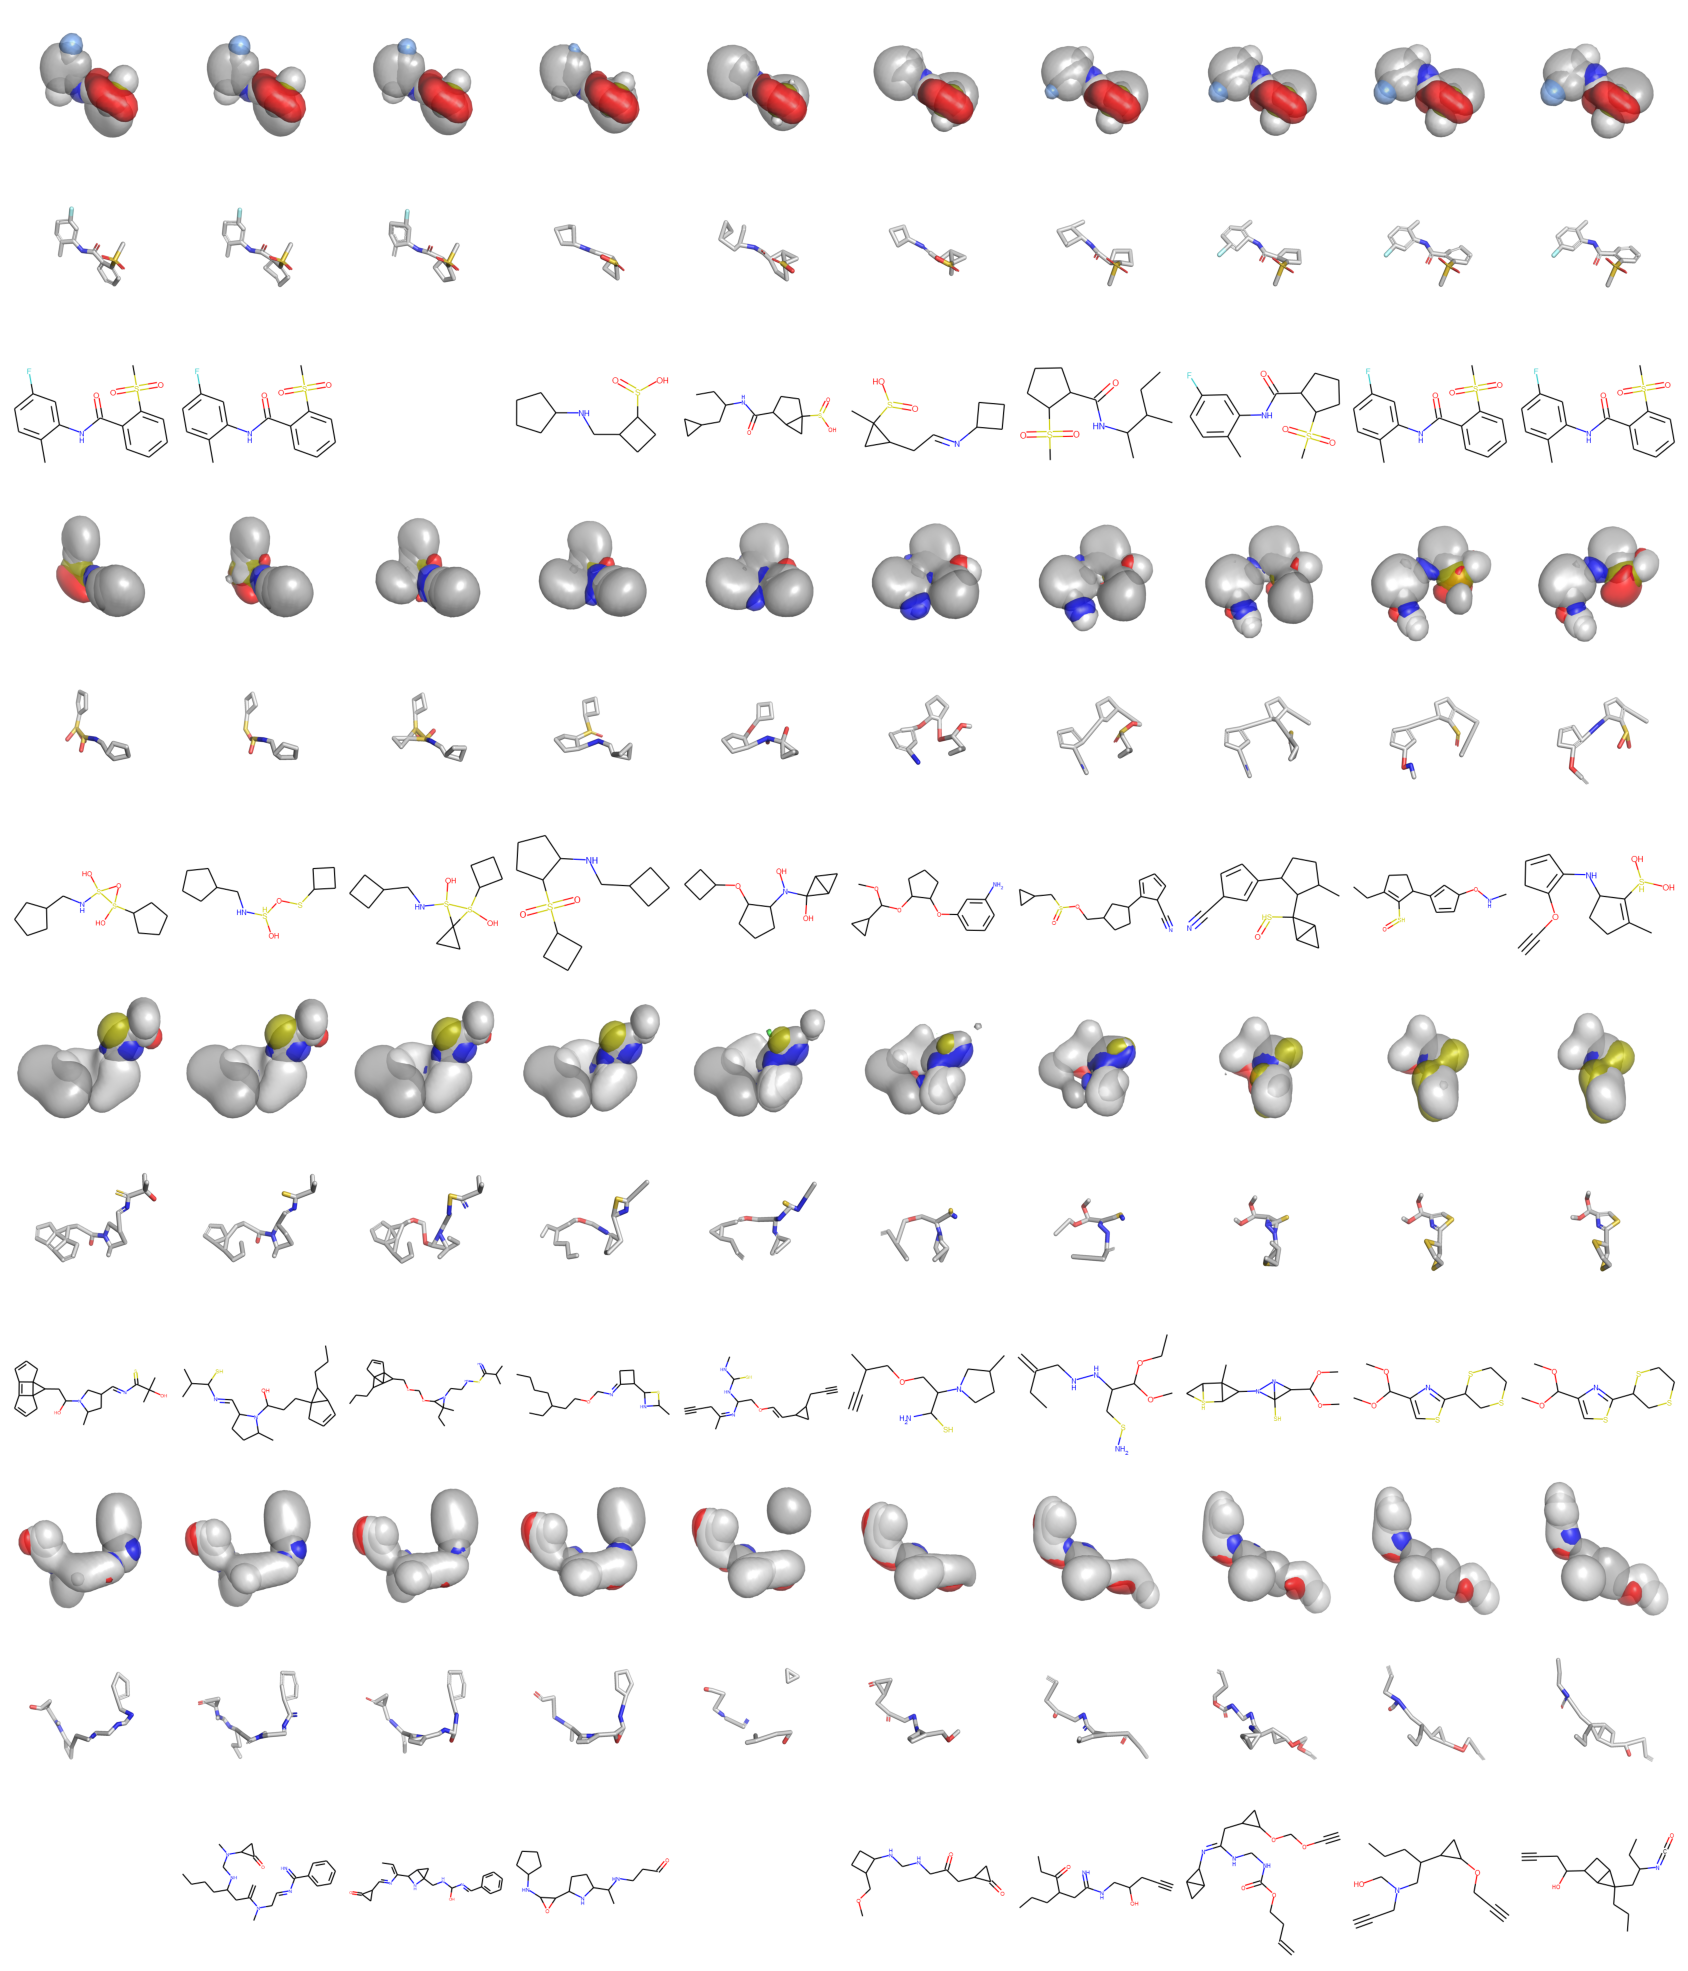

In [599]:
import matplotlib.image as mpimg

def smi_to_image(smi):
    mol = Chem.MolFromSmiles(smi)
    return Chem.Draw.MolToImage(mol)

y = ['lig_name', 'sample_idx', 'lig_gen_norm', 'lig_latent_norm', 'lig_gen_fit_add_valid', 'lig_gen_fit_add_SMILES']

lat_df['grid_image_file']   = lat_df[['latent_name', 'lig_idx', 'sample_idx']].apply(
    lambda x: latent_dir + '\\images\\' + x.iloc[0] + '\\grids\\grid{}_{:04d}.png'.format(x.iloc[1], x.iloc[2] + 1), axis=1)

lat_df['struct_image_file'] = lat_df[['latent_name', 'lig_idx', 'sample_idx']].apply(
    lambda x: latent_dir + '\\images\\' + x.iloc[0] + '\\structs\\struct{}_{:04d}.png'.format(x.iloc[1], x.iloc[2] + 1), axis=1)

_lat_df = lat_df.set_index(['latent_idx', 'interp_idx'])



n_rows = 3*len(latent_names)
n_cols = len(interp_idxs)
width = height = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(width*n_cols, height*n_rows))

for latent_idx in range(len(latent_names)):
    for ax_idx, interp_idx in enumerate(interp_idxs):
        row = _lat_df.loc[latent_idx, interp_idx]

        ax = axes[3*latent_idx + 0, ax_idx]
        grid_im = mpimg.imread(row['grid_image_file'])
        ax.imshow(grid_im, aspect='auto')

        ax = axes[3*latent_idx + 1, ax_idx]
        struct_im = mpimg.imread(row['struct_image_file'])
        ax.imshow(struct_im, aspect='auto')

        ax = axes[3*latent_idx + 2, ax_idx]
        smi = row['lig_gen_fit_add_SMILES']
        try:
            mol_im = smi_to_image(smi)
            ax.imshow(mol_im, aspect='auto')
        except ValueError:
            pass

        for j in range(3):
            ax = axes[3*latent_idx + j, ax_idx]
            ax.set_xticklabels([])
            ax.set_yticklabels([])
    
sns.despine(fig, top=True, bottom=True, left=True, right=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('latent_interp1.png', bbox_inches='tight')
os.getcwd()

In [516]:
mol_df = lat_df = fit_df[(fit_df['dataset'] == 'pubchem') &
                (fit_df['iteration'] == 100000)]

ae_mol_df =
vae_mol_df =
pri_mol_df =

In [ ]:
n_rows = 3
n_cols = len(interp_idxs)
width = height = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(width*n_cols, height*n_rows))

for ax_i, interp_i in enumerate(interp_idxs):
    row = lat_df.loc[interp_i]
    
    ax = axes[0,ax_i]
    grid_im = mpimg.imread(row['grid_image_file'])
    ax.imshow(grid_im, aspect='auto')
    
    ax = axes[1,ax_i]
    struct_im = mpimg.imread(row['struct_image_file'])
    ax.imshow(struct_im, aspect='auto')
    
    ax = axes[2,ax_i]
    smi = row['lig_gen_fit_add_SMILES']
    try:
        mol_im = smi_to_image(smi)
        ax.imshow(mol_im, aspect='auto')
    except ValueError:
        pass
    
    for j in range(3):
        ax = axes[j,ax_i]
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
sns.despine(fig, top=True, bottom=True, left=True, right=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('latent_interp1.png', bbox_inches='tight')
os.getcwd()